In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import os
from os.path import join
from tqdm.autonotebook import trange, tqdm
import pickle as pkl
import torch
import numpy as np
import pandas as pd
# from lpips import LPIPS÷
import seaborn as sns
import matplotlib.pyplot as plt
from easydict import EasyDict as edict
import sys
sys.path.append(r"/Users/binxuwang/Github/Neuro-ActMax-GAN-comparison/")
from core.utils.plot_utils import show_imgrid, save_imgrid, saveallforms
from core.utils.montage_utils import crop_all_from_montage, make_grid_np, build_montages, crop_from_montage, make_grid
from neuro_data_analysis.neural_data_lib import load_neural_data, extract_all_evol_trajectory_psth, pad_psth_traj
from neuro_data_analysis.neural_data_utils import get_all_masks

In [29]:
tabdir = r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Stats_tables"
source_data_dir = r"/Users/binxuwang/Library/CloudStorage/OneDrive-HarvardUniversity/Manuscript_BigGAN/Submissions/Manuscript_BigGAN - NatNeuro/2025-10-Accepted-In-Principle-Docs/SourceData/Fig3_Source_data"

In [30]:
imgdist_df = pd.read_csv(join(tabdir, "proto_imdist_psth_covstr_sim_df.csv"), index_col=0)
imgdist_df.to_csv(join(source_data_dir, "Fig3G_proto_imdist_psth_covstr_sim_df.csv"))

In [9]:
meta_act_df = pd.read_csv(join(tabdir, "meta_activation_stats.csv"), )
Amsk, Bmsk, V1msk, V4msk, ITmsk, \
    length_msk, spc_msk, sucsmsk, \
    bsl_unstable_msk, bsl_stable_msk, validmsk = get_all_masks(meta_act_df)
bothsucmsk = (meta_act_df.p_maxinit_0 < 0.05) & (meta_act_df.p_maxinit_1 < 0.05)
anysucmsk = (meta_act_df.p_maxinit_0 < 0.05) | (meta_act_df.p_maxinit_1 < 0.05)

total number of experiments: 170
total number of valid experiments: 154
total number of valid experiments with suc: 133
Exluded:
  - short: 8
  - unstable baseline: 6
  - not fc6-BigGAN: 3


In [34]:
validmsk

0       True
1      False
2       True
3       True
4       True
       ...  
165     True
166     True
167     True
168     True
169     True
Length: 170, dtype: bool

In [37]:
meta_act_df["valid"] = validmsk
meta_act_df.to_csv(join(source_data_dir, "Fig3_meta_df.csv"))

In [13]:
from scipy.stats import pearsonr, spearmanr

def scatter_corr(df, x, y, ax=None, corrtype="pearson", **kwargs):
    """wrapper over sns.scatterplot to add correlation coefficient and p-value to annotation. """
    if ax is None:
        ax = plt.gca()
    # ax.scatter(df[x], df[y], **kwargs)
    sns.scatterplot(data=df, x=x, y=y, ax=ax, **kwargs)
    # scipy pearsonr
    validmsk = np.logical_and(np.isfinite(df[x]), np.isfinite(df[y]))
    if corrtype.lower() == "pearson":
        rho, pval = pearsonr(df[x][validmsk], df[y][validmsk], )
    elif corrtype.lower() == "spearman":
        rho, pval = spearmanr(df[x][validmsk], df[y][validmsk], )
    else:
        raise NotImplementedError
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f"{x} vs. {y}\ncorr={rho:.3f} p={pval:.1e} n={validmsk.sum()}")
    return ax, rho, pval

In [23]:
print(list(imgdist_df.columns))


['Expi', 'cosine_reevol_resnet_L3_m', 'cosine_reevol_resnet_L4_m', 'cosine_reevol_resnet_avgpool', 'cosine_reevol_alexnet_fc6', 'cosine_reevol_alexnet_fc7', 'cosine_reevol_vit_cls', 'cosine_reevol_vit_token_m', 'cosine_maxblk_resnet_L3_m', 'cosine_maxblk_resnet_L4_m', 'cosine_maxblk_resnet_avgpool', 'cosine_maxblk_alexnet_fc6', 'cosine_maxblk_alexnet_fc7', 'cosine_maxblk_vit_cls', 'cosine_maxblk_vit_token_m', 'reevol_G_resnet_L3', 'reevol_G_resnet_L4', 'Expi_alt', 'reevol_G_resnet_L3_BGalt', 'reevol_G_resnet_L4_BGalt', 'reevol_G_resnet_L3_FCalt', 'reevol_G_resnet_L4_FCalt', 'reevol_pix_resnet_L3', 'reevol_pix_resnet_L4', 'reevol_pix_resnet_L3_BGalt', 'reevol_pix_resnet_L4_BGalt', 'reevol_pix_resnet_L3_FCalt', 'reevol_pix_resnet_L4_FCalt', 'maxblk_resnet_L3', 'maxblk_resnet_L4', 'maxblk_resnet_L3_BGalt', 'maxblk_resnet_L4_BGalt', 'maxblk_resnet_L3_FCalt', 'maxblk_resnet_L4_FCalt', 'normalizer', 'psth_corr', 'psth_MAE', 'psth_MSE', 'psth_corr_smooth', 'psth_MAE_smooth', 'psth_MSE_smooth'

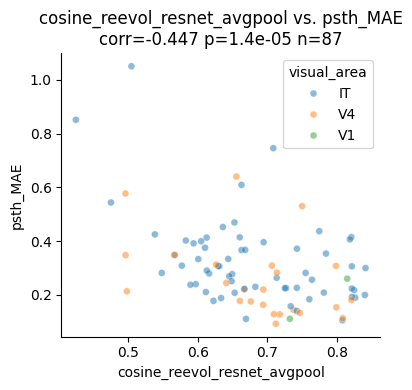

In [20]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'cosine_reevol_resnet_avgpool',
                  'psth_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()

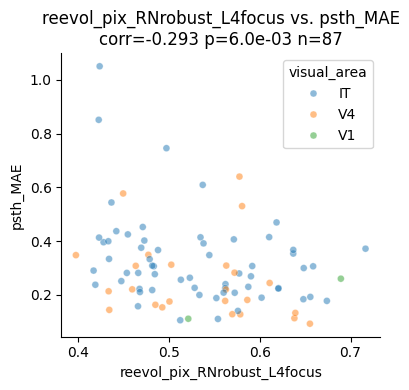

In [25]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'reevol_pix_RNrobust_L4focus',
                  'psth_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()

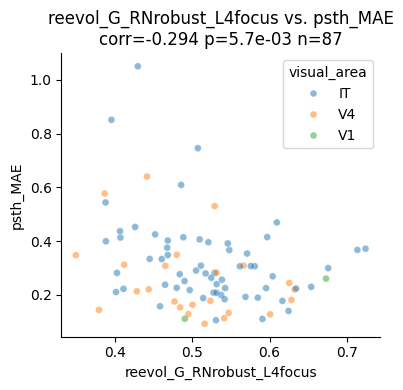

In [26]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'reevol_G_RNrobust_L4focus',
                  'psth_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()

In [38]:
imgdist_df = pd.read_csv(join(source_data_dir, "Fig3G_proto_imdist_psth_covstr_sim_df.csv"))
meta_act_df = pd.read_csv(join(source_data_dir, "Fig3_meta_df.csv"))

validmsk = meta_act_df["valid"]
bothsucmsk = (meta_act_df.p_maxinit_0 < 0.05) & (meta_act_df.p_maxinit_1 < 0.05)
anysucmsk = (meta_act_df.p_maxinit_0 < 0.05) | (meta_act_df.p_maxinit_1 < 0.05)

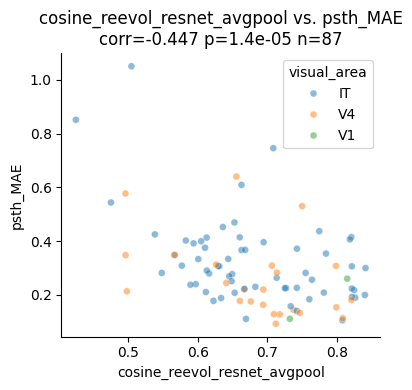

In [32]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'cosine_reevol_resnet_avgpool',
                  'psth_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()

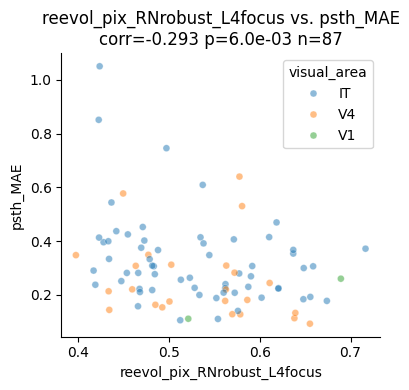

In [33]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'reevol_pix_RNrobust_L4focus',
                  'psth_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()

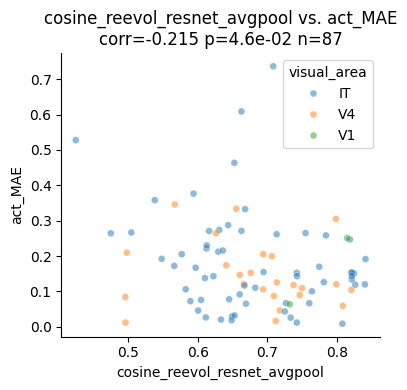

In [39]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'cosine_reevol_resnet_avgpool',
                  'act_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()

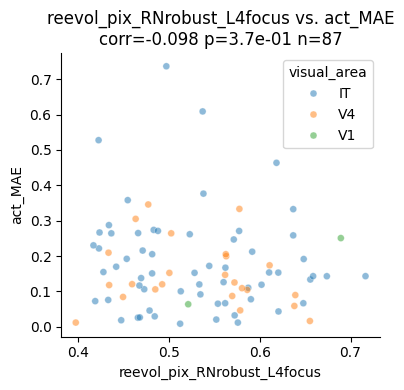

In [40]:
fig = plt.figure(figsize=[4, 4])
ax, rho, pval = scatter_corr(imgdist_df[validmsk & bothsucmsk ],
                   'reevol_pix_RNrobust_L4focus',
                  'act_MAE', s=25, alpha=0.5, hue='visual_area')
plt.tight_layout()
plt.show()